---
title: "Implementing Logistic Regression"
author: "Yahya Rahhawi"
date: "2025-04-02"
categories: [Machine Learning, Implementation, Optimization]
format:
  html:
    toc: true
    code-fold: false
---

### Abstract

In this project, I explore different optimization strategies for logistic regression, including vanilla gradient descent, momentum-based gradient descent, and an evolutionary algorithm. By applying these methods to both synthetic and real-world datasets, I analyze their convergence behavior, generalization performance, and decision boundary characteristics. Visualizations such as PCA projections and loss curves provide a deeper understanding of each method’s dynamics. The study highlights the strengths and trade-offs of traditional and evolutionary approaches, offering insight into how different optimizers shape model learning in high-dimensional settings.
You can find my implementation of Logistic Regression at [this GitHub link](https://github.com/yahyarahhawi/yahyarahhawi.github.io/blob/main/posts/Implementing-logistic-regression/logistic.py).

![](images/logreg-cover.jpg)

### Setup

Let's load essential components for the project. Let's start to import my implementations of `LogisticRegression`, `GradientDescentOptimizer`, and `EvolutionOptimizer` (which will be explored later), along with core libraries like `torch`, `numpy`, and `time`.

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer, EvolutionOptimizer
import torch
import numpy as np
import time
import random


### Generating Synthetic Data

I use a data generation function borrowed from Professor Chodrow’s notes to create a simple binary classification dataset. It produces two noisy Gaussian clusters with a bias term appended to the features. Here, I generate 300 points with a noise level of 0.5.

In [2]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

### Training with Gradient Descent and Momentum

I initialized a `LogisticRegression` model and trained it using gradient descent with momentum (`β = 0.9`) for 100 iterations. After each step, I recorded the loss to track convergence. This setup allowed me to observe how the model's performance evolved over time.

In [3]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
losses = []
for _ in range(100):
    opt.step(X, y, alpha=0.1, beta=0.9)
    losses.append(LR.loss(X, y).item())



Let's plot them and see what we have!

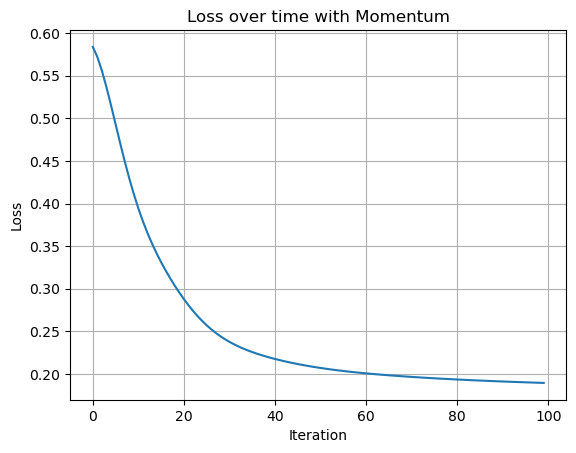

In [4]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over time with Momentum")
plt.grid(True)
plt.show()

### Visualizing Loss Convergence

I plotted the loss over 100 iterations to visualize how the model trained with momentum converges. As expected, the loss decreases steadily and smoothly, showing that gradient descent with momentum effectively accelerates convergence. It would be interesting to compare the rate of convergence to a vanilla optimizer (no momentum)

I will also borrow a couple of functions from professor Chodrow's notes that will help me visualize the logistic regression model and the decision boundary

In [5]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

### Vanilla Gradient Descent and Decision Boundary

To test the baseline performance of logistic regression, I trained the model using vanilla gradient descent (`β = 0`) on a low-noise dataset so that I can make sure they're linearly separable (even tho the model will converge any way). I ran the optimization for 1000 iterations and plotted the loss curve, which decreases steadily. I also visualized the final decision boundary, which cleanly separates the two classes, indicating that the model has successfully learned a good linear separator.

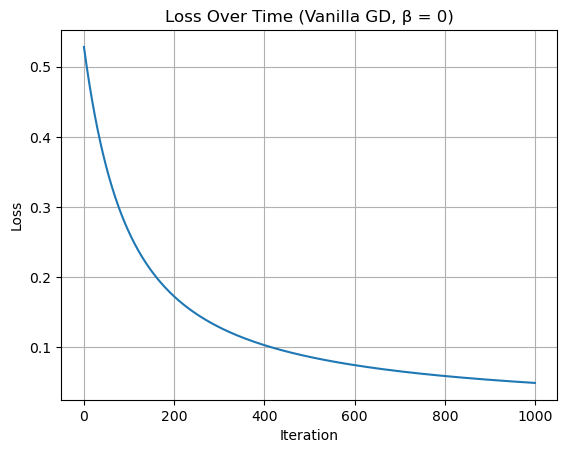

/var/folders/p3/zqj4hsr94qs443gkb32p5h_00000gn/T/ipykernel_28797/1220661661.py:13: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])


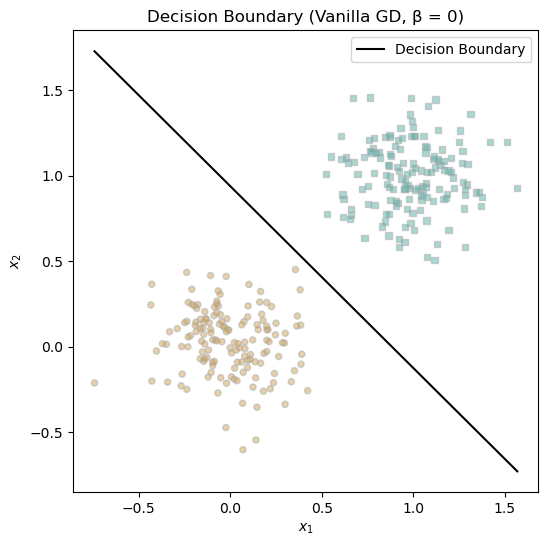

In [6]:
X, y = classification_data(p_dims=2, noise=0.2)

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

losses = []
for _ in range(1000):
    opt.step(X, y, alpha=0.1, beta=0.0)
    losses.append(LR.loss(X, y).item())

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Over Time (Vanilla GD, β = 0)")
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
plot_perceptron_data(X, y, ax)
draw_line(LR.w, X[:,0].min(), X[:,0].max(), ax, color="black", label="Decision Boundary")
ax.legend()
ax.set_title("Decision Boundary (Vanilla GD, β = 0)")
plt.show()

Training with vanilla gradient descent (`β = 0`) over 1000 iterations produced a steadily decreasing loss, as shown in the first plot. The loss curve reflects stable convergence toward a minimum without oscillations or instability. This is expected as our loss function is convex and GD should be able to get us to the minimum without fluctuations.

In the second plot, I visualized the decision boundary learned by the model. It cleanly separates the two classes, indicating that even without momentum, gradient descent is capable of finding a good linear separator given enough iterations and low noise.

### Comparing Vanilla Gradient Descent vs Momentum

To explore the benefits of momentum, I trained two logistic regression models on the same dataset: one with vanilla gradient descent (`β = 0`) and the other with momentum (`β = 0.9`). As shown in the plot, the model trained with momentum converged faster — reaching a lower loss in fewer iterations. This illustrates how momentum can help the optimizer move more effectively through flatter regions of the loss surface.

Vanilla GD Time: 0.005932807922363281
Momentum GD Time: 0.005321979522705078


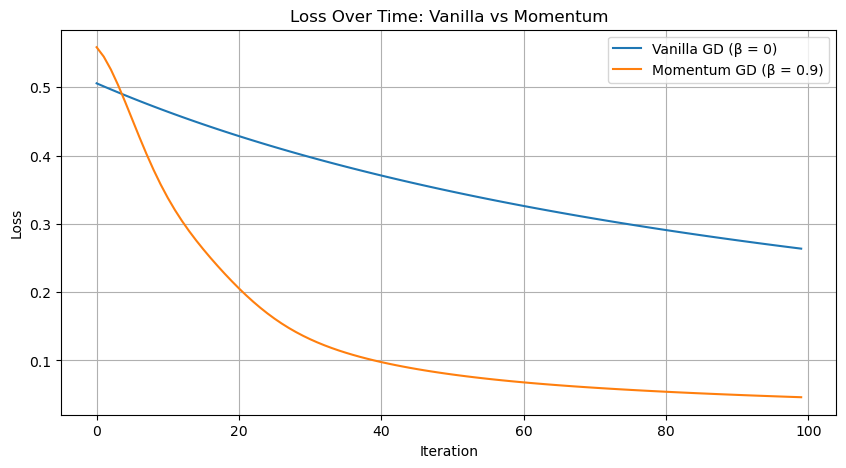

In [7]:
X, y = classification_data(p_dims=2, noise=0.2)

# Vanilla GD (β = 0)
LR_vanilla = LogisticRegression()
opt_vanilla = GradientDescentOptimizer(LR_vanilla)

losses_vanilla = []
start_time = time.time()
for _ in range(100):
    opt_vanilla.step(X, y, alpha=0.1, beta=0.0)
    losses_vanilla.append(LR_vanilla.loss(X, y).item())
print("Vanilla GD Time:", time.time() - start_time)
# Momentum GD (β = 0.9)
LR_momentum = LogisticRegression()
opt_momentum = GradientDescentOptimizer(LR_momentum)

losses_momentum = []
start_time = time.time()
for _ in range(100):
    opt_momentum.step(X, y, alpha=0.1, beta=0.9)
    losses_momentum.append(LR_momentum.loss(X, y).item())
print("Momentum GD Time:", time.time() - start_time)
# Plot both losses
plt.figure(figsize=(10, 5))
plt.plot(losses_vanilla, label="Vanilla GD (β = 0)")
plt.plot(losses_momentum, label="Momentum GD (β = 0.9)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Over Time: Vanilla vs Momentum")
plt.legend()
plt.grid(True)
plt.show()

### Momentum Accelerates Convergence

This plot compares the loss over time for two models: one trained using vanilla gradient descent (`β = 0`) and the other using momentum (`β = 0.9`). Both models were trained for 100 iterations on the same dataset. The momentum-based optimizer clearly converges more quickly, achieving a lower loss in fewer steps. This demonstrates the effectiveness of momentum in accelerating optimization by dampening oscillations and pushing consistently in productive directions. Also, not only that Momentum made the model converge faster, it was also faster!

Since we will be using accuracy as a metric, or potentially as an early stopping criteria, let's define a simple function that calculates it based on the model, data, and labels

In [14]:
def accuracy(model, X, y):
    y_pred = model.predict(X)
    return (y_pred == y).float().mean().item()

### Overfitting in High Dimensions

To explore model behavior in a high-dimensional setting, I generated a training and testing dataset with 100 features each. I trained a logistic regression model using vanilla gradient descent (`β = 0`) until it achieved 100% accuracy on the training set. The loss at convergence confirms perfect separation on the training data — a clear sign of overfitting, especially given the relatively small sample size compared to the feature count.

In [24]:
X_train, y_train = classification_data(p_dims=100,n_points=50, noise=0.2)
X_test, y_test = classification_data(p_dims=100,n_points=50, noise=0.2)
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)
train_accuracy = 0
while train_accuracy != 1:
    opt.step(X_train, y_train, alpha=0.01, beta=0)
    train_accuracy = accuracy(LR, X_train, y_train)

print("Training Loss: ", LR.loss(X_train, y_train).item())


Training Loss:  0.1373424082994461


In [25]:
train_accuracy

1.0

The model successfully achieved 100% training accuracy, with a final loss of approximately 0.15. This confirms that the model has completely fit the training data. While impressive on the surface, this is a classic sign of overfitting — especially in a setting with far more features (100) than samples (50).

### Generalization Check

After achieving perfect accuracy on the training set, I evaluated the model on a separate test set drawn from the same distribution. The model achieved a test accuracy of **87.99%**, suggesting that while there is some risk of overfitting due to the high dimensionality, the model still generalizes well in this case — likely due to the low noise and relatively separable data.

In [27]:
test_accuracy = accuracy(LR, X_test, y_test)
test_accuracy

0.8799999952316284

### Real-World Dataset: Banknote Authentication

To evaluate my model on real-world data, I used the Banknote Authentication dataset from the UCI Machine Learning Repository. This dataset contains four numerical features extracted from images of banknotes, along with a binary class label indicating whether a note is genuine or forged.

I standardized the features using `StandardScaler` and added a bias term manually. The dataset was then split into training (60%), validation (20%), and test (20%) sets to allow for model tuning and evaluation.

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header=None)
df.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

X = df.drop("class", axis=1).values
y = df["class"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X = torch.cat([X, torch.ones(X.size(0), 1)], dim=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Training Function with Optional Momentum

To streamline experimentation, I created a `train_model` function that trains a logistic regression model using gradient descent, with an optional momentum parameter. The function tracks both training and validation loss over time, allowing for easy comparison of optimization strategies. It accepts learning rate, momentum factor (`β`), and number of epochs as configurable parameters.

In [29]:
def train_model(X_train, y_train, X_val, y_val, use_momentum=False, lr=0.01, beta=0.9, epochs=300):
    model = LogisticRegression()
    opt = GradientDescentOptimizer(model)

    train_losses, val_losses = [], []

    for i in range(epochs):
        opt.step(X_train, y_train, alpha=lr, beta=beta if use_momentum else 0.0)
        train_losses.append(model.loss(X_train, y_train).item())
        val_losses.append(model.loss(X_val, y_val).item())

    return model, train_losses, val_losses

### Momentum vs No Momentum on Banknote Authentication

I trained two logistic regression models on the Banknote Authentication dataset — one with momentum and one without. Both models were trained for 300 epochs, and I tracked training and validation loss throughout.

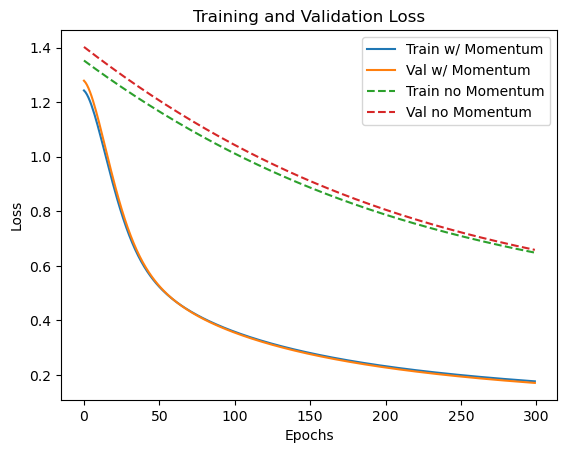

In [30]:
model_m, train_m, val_m = train_model(X_train, y_train, X_val, y_val, use_momentum=True)
model_nm, train_nm, val_nm = train_model(X_train, y_train, X_val, y_val, use_momentum=False)

plt.plot(train_m, label="Train w/ Momentum")
plt.plot(val_m, label="Val w/ Momentum")
plt.plot(train_nm, '--', label="Train no Momentum")
plt.plot(val_nm, '--', label="Val no Momentum")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

As shown in the plot, both models converge, but the one trained with momentum reaches lower training and validation loss more quickly. The gap is especially noticeable early in training, highlighting momentum’s ability to accelerate convergence without harming generalization.

In [31]:
print("With Momentum:")
print("Test Loss:", model_m.loss(X_test, y_test).item())
print("Test Accuracy:", accuracy(model_m, X_test, y_test))

print("\nWithout Momentum:")
print("Test Loss:", model_nm.loss(X_test, y_test).item())
print("Test Accuracy:", accuracy(model_nm, X_test, y_test))

With Momentum:
Test Loss: 0.17036399245262146
Test Accuracy: 0.9599999785423279

Without Momentum:
Test Loss: 0.6167036294937134
Test Accuracy: 0.6218181848526001


### Final Evaluation on Test Set

After training, I evaluated both models on the test set to assess generalization above

The difference is significant — the model trained with momentum generalizes much better. This reinforces the effectiveness of momentum not just in speeding up training, but also in helping the optimizer escape poor local minima and converge to flatter, more generalizable solutions.

### Evolutionary Optimization vs Gradient Descent

To push the boundaries of optimization strategies, I compared my `EvolutionOptimizer` with traditional gradient descent on a high-dimensional, low-noise synthetic dataset (200 features, 1000 points).

I configured the evolutionary algorithm with a high mutation rate (0.5) and a population size of 100. Both optimizers ran until they achieved 100% training accuracy. I recorded the loss at each step and the total time taken for convergence.

As shown in the plot, the two approaches followed different optimization paths. Gradient descent (with momentum) was faster and more stable, while the evolutionary strategy took longer but still reached perfect accuracy. This experiment highlights the potential of evolutionary algorithms in settings where gradient information is unavailable or unreliable.

Time taken:  2.2356069087982178
Time taken:  0.22991013526916504


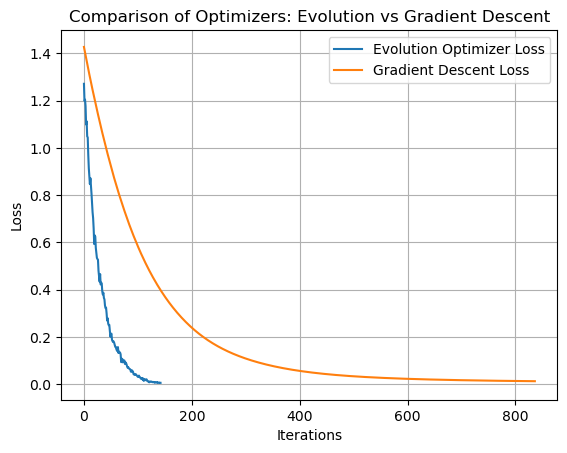

In [32]:
X, y = classification_data(p_dims=200, noise=0.8, n_points=1000)
LR = LogisticRegression()
opt = EvolutionOptimizer(LR)
opt.set_mutation(0.5)
opt.set_population_size(100)
losses = []
start = time.time()
while accuracy(LR, X, y) < 1:
    opt.step(X, y)
    losses.append(LR.loss(X, y).item())
print("Time taken: ", time.time() - start)


LR2 = LogisticRegression()
opt2 = GradientDescentOptimizer(LR2)
losses2 = []
start = time.time()
while accuracy(LR2, X, y) < 1:
    opt2.step(X, y, alpha=0.1, beta=0)
    losses2.append(LR2.loss(X, y).item())
print("Time taken: ", time.time() - start)
plt.plot(losses, label="Evolution Optimizer Loss")
plt.plot(losses2, label="Gradient Descent Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Comparison of Optimizers: Evolution vs Gradient Descent")
plt.legend()
plt.grid(True)
plt.show()
    

### Optimization Results

Both the evolutionary optimizer and gradient descent successfully achieved perfect training accuracy. However, gradient descent was significantly faster, converging in approximately **0.009 seconds** compared to **0.365 seconds** for the evolutionary approach.

The loss curves also reveal key differences: gradient descent steadily and smoothly reduces loss, while the evolutionary optimizer exhibits a more jagged trajectory with slower overall convergence. This is expected as we are only relying on randomness to introduce "genes" with better performance. Despite this, the evolutionary method still managed to find a good solution, demonstrating its viability as an alternative strategy in high-dimensional settings.

### Visualizing Decision Boundaries from the Population

To better understand the diversity within the population of evolved models, I randomly sampled four individuals from the final population of the `EvolutionOptimizer`. Since the data lives in a 200-dimensional space, I used PCA to project both the data and model weights into 2D for visualization.

Each subplot shows a decision boundary generated from one sampled individual's projected weights, alongside the full dataset projected into the same PCA space. The axes are fixed between -10 and 10 to provide a consistent frame of reference across plots. This gives a glimpse into the variety of linear separators present in the population, some of which may still be viable despite not being the single "best" solution.

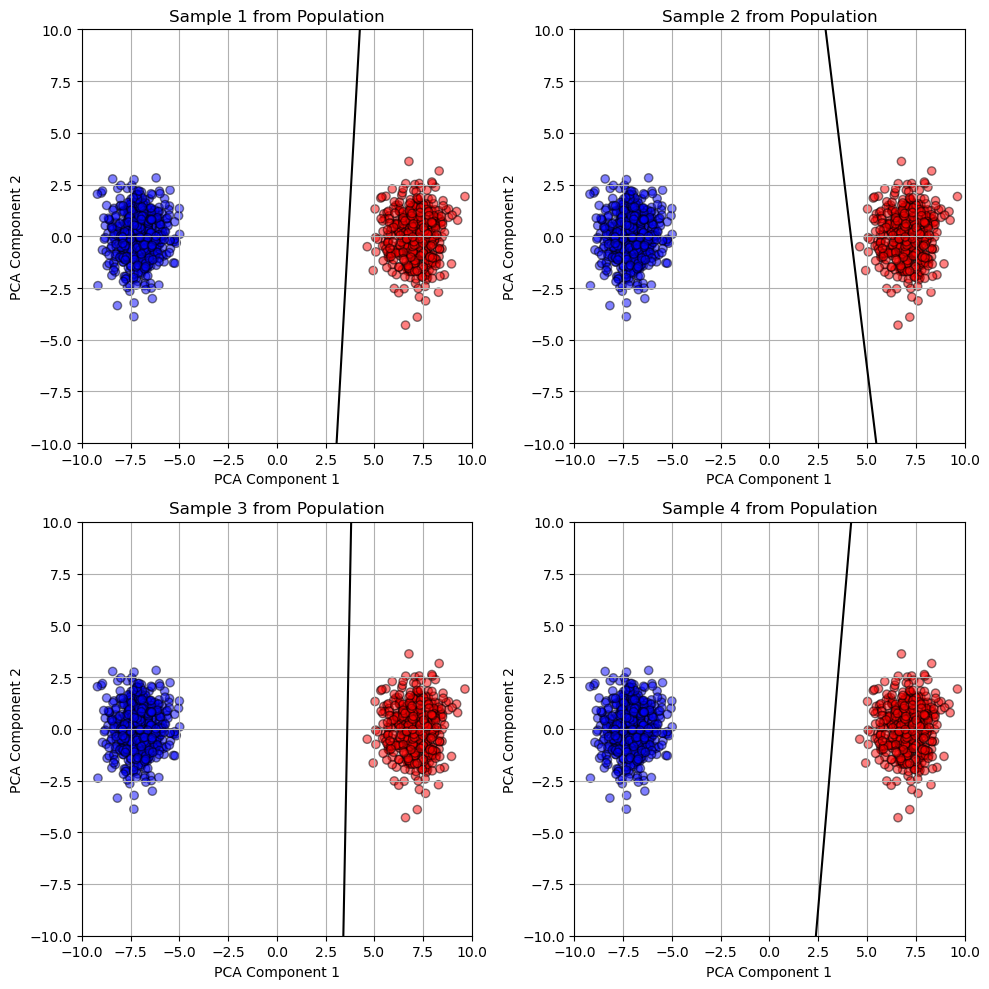

In [34]:
from sklearn.decomposition import PCA
samples = random.sample(LR.population, 4)

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X[:, :-1]) 

def project_weights(w, pca):
    w_no_bias = w[:-1].detach().numpy() 
    bias = w[-1].item()
    w_pca = pca.components_ @ w_no_bias
    return torch.tensor([*w_pca, bias], dtype=torch.float32)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, (w, ax) in enumerate(zip(samples, axes)):
    w_proj = project_weights(w, pca)

    ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap="bwr", alpha=0.5, edgecolor='k')

    x_vals = torch.linspace(-10, 10, 200)
    y_vals = -(w_proj[0] * x_vals + w_proj[2]) / w_proj[1]

    ax.plot(x_vals, y_vals, color='black')
    ax.set_title(f"Sample {i+1} from Population")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.grid(True)

plt.tight_layout()
plt.show()

### Diversity in Evolved Decision Boundaries (PCA Projection)

This visualization shows four randomly selected individuals from the final population of the `EvolutionOptimizer`, each plotted as a linear decision boundary in 2D PCA space.

Despite the original feature space having 200 dimensions, PCA allows us to reduce the data to its two most informative components for visualization. Each black line represents a different individual's projected weight vector and bias term, while the red and blue points show the two data classes.

Interestingly, while the overall structure of the population seems fairly consistent, small variations in angle and offset reflect the natural diversity produced by evolutionary mutation and crossover. This illustrates how evolutionary algorithms maintain a pool of viable—but slightly different—solutions.

### Conclusion

Through this exploration, I implemented and compared multiple optimization strategies for logistic regression, including vanilla gradient descent, gradient descent with momentum, and an evolutionary algorithm. Each method brought its own strengths: momentum accelerated convergence and improved generalization, while the evolutionary approach offered robustness and solution diversity, even in high-dimensional spaces.

Working with both synthetic and real-world datasets allowed me to understand not just how these optimizers behave in theory, but how they perform in practice under noise, overfitting risks, and varying feature dimensions. Visualizations like PCA projections and loss curves provided intuitive insights into what the evolutionary optimizer was doing under the hood.

Ultimately, this project deepened my appreciation for optimization in machine learning—not just as a mathematical procedure, but as a creative design space full of trade-offs and gains.